<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project1_numerical_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1: Diffusion equation

In this project we will use several methods to solve the diffusion equation:

$$ \partial_t c = \kappa \partial_x^2 c $$

This project consists of two notebooks. First, in this notebook, we will solve this equation using second order finite differences to approximate the $x$-derivatives, and we will use both the explict Euler and Crank-Nicolson timestepping methods.

In the second notebook for this project, we will learn how to use Dedalus to solve the same problem using spectral methods.

The objective for this notebook is learn about spatial discretization and to compare the stability, accuracy, and speed of the Explicit euler and Crank-Nicolson methods when applied to the diffusion equation.

Student tasks are in [Section 2.1](#section2pt1) and [Section 2.2](#section2pt2).

Before we start, load in the required libraries

In [181]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time


Now, define two functions to timestep the diffusion equation. The code below timesteps the diffusion equation using the expicit Euler method. The function takes in a vector of discrete positions, `x`, discrete times, `t`, and the diffusivity, `kappa`. The vectors `x` and `t` dictate the discretization of the problem in space and time, and the grid spacing must be constant in space and time. The boundary conditions are $\partial_x c=0$ at the starting and ending points in `x`.

In [182]:
def EE(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods

    start_time = time.time()  # Start a timer

    # Infer the uniform grid spacing:
    dx = (x[-1] - x[0]) / (len(x) - 1); dt = (t[-1] - t[0]) / (len(t) - 1)

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    # Builds a coefficient matrix, such that M*c is the discrete version of d/dx(c)
    M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2

    # Turn M into a sparse matrix to save memory and improve speed
    M = sp.csr_matrix(M)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt):  # loop over the number of timesteps
      c[:,k] = c[:,k-1] + dt * kappa * M @ c[:,k-1]
      # Enforce the boundary conditions (no flux)
      c[0, k] = c[1, k]
      c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    print(f"Explicit Euler method took {end_time - start_time:.2f} seconds")

    return c

Similarly, the function below timesteps the diffusion equation with the Crank-Nicolson method

In [183]:
def CN(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods
    start_time = time.time()  # Start a timer

    # Infer the uniform grid spacing:
    dx = (x[-1] - x[0]) / (len(x) - 1); dt = (t[-1] - t[0]) / (len(t) - 1)

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    # build a coefficient matrix, such that M*c is the discrete version of d/dx(c)
    M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2

    # Turn M into a sparse matrix to save memory and improve speed:
    M = sp.csr_matrix(M)

    A = sp.eye(Nx) - 0.5 * dt * kappa * M  # This matrix appears on the LHS in the C-N scheme
    A_inv = spla.inv(A) # Calculate the inverse of A (this only needs to be done once)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt): # loop over the number of timesteps
        c[:, k] = A_inv @ (c[:, k-1] + 0.5 * dt * kappa * (M @ c[:, k-1]))
        # Enforce the boundary conditions
        c[0, k] = c[1, k]
        c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    print(f"Crank-Nicolson method took {end_time - start_time:.2f} seconds")

    return c

Next, create a function to set the initial conditions. The exact solution to the unbounded diffusion equation with a delta function initial condition is:

$$\left(\frac{1}{4\pi\kappa t}\right)^{1/2}e^{-x^2/(4\kappa t)}$$

The function below sets the initial condition by evaluating the exact solution at a given time. Note that it is important that we don't evaluate the exact solution at `t_ic=0` since this will return a delta function which will be undefined on our finite grid. The value of `t_ic` is set within the `EE` and `CN` functions.

In [184]:
# Function to set the initial condition from the exact solution at time t_start
def set_ics(x, kappa, t_ic):
    c_ic = (4*np.pi*kappa*t_ic)**(-0.5)*np.exp(-x**2 / (4*kappa*t_ic))
    # Enforce the boundary conditions
    c_ic[0] = c_ic[1]
    c_ic[-1] = c_ic[-2]
    return c_ic


Finally, define some parameters and the x and t vectors:

In [185]:
# Defining parameters
kappa = 0.001  # diffusivity

# Timestepping parameters
t_start = 0  # start time (note that this is not the same time used to evaluate the exact solution to set the ICs)
t_end = 10  # end time
Nt = 1000  # number of timesteps

# Size of the physical domain
x_start = -1
x_end = 1
Nx = 100

t = np.linspace(t_start, t_end, Nt)  # Create a vector of times
x = np.linspace(x_start, x_end, Nx)  # Create a vector for x

Run each method once:

In [186]:
# Run the simulations
c_EE = EE(x, t, kappa) # explicit Euler
c_CN = CN(x, t, kappa) # Crank-Nicolson

Explicit Euler method took 0.06 seconds
Crank-Nicolson method took 0.07 seconds


and finally, plot the results side-by-side

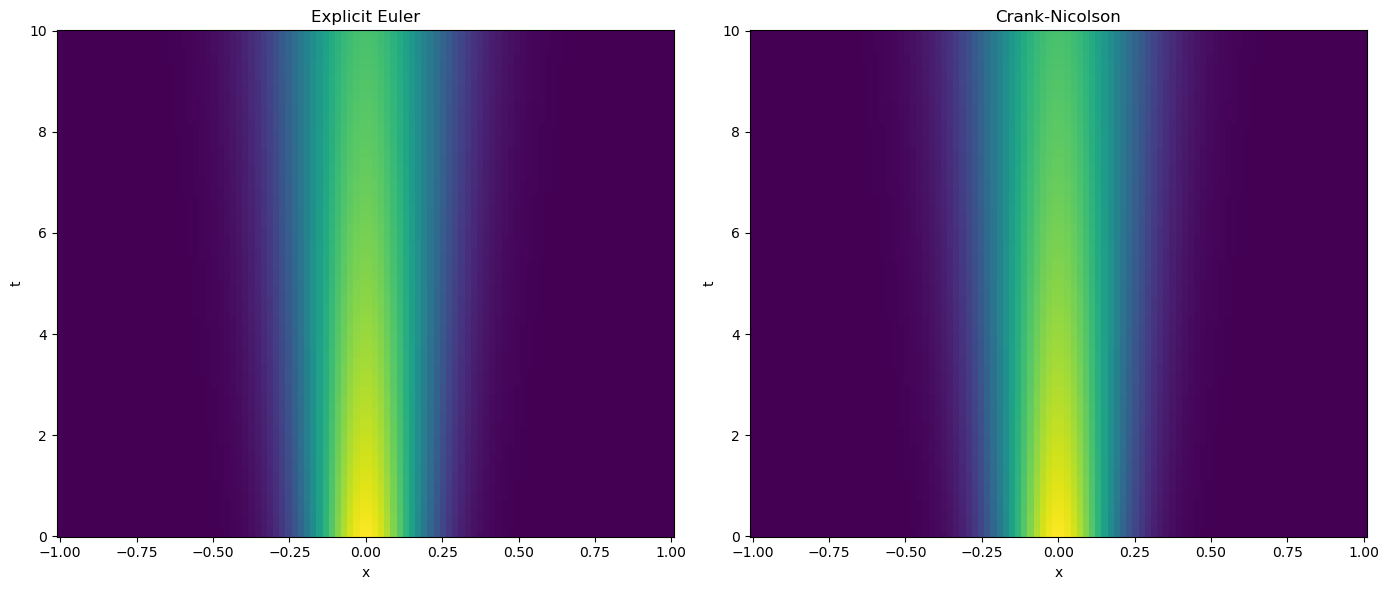

In [187]:
# Plot the results
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.pcolormesh(x, t, c_EE.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Explicit Euler')

plt.subplot(1, 2, 2)
plt.pcolormesh(x, t, c_CN.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Crank-Nicolson')

plt.tight_layout()
plt.show()

## 2. Student investigation

### 2.1 Stability
<a id='section2pt1'></a>
The explicit Euler and Crank-Nicolson methods have very different stability properties. To explore this, try increasing the timestep (reduce the number of timesteps) and see how each method responds. How does the stability depend on `Nx`? Discuss your findings below (~1 paragraph)

INSERT COMMENTS HERE

Initial values used: Nt=1000, Nx=100, kappa=0.001


1. When the timestep is inceased (by decreasing Nt to 2) or decreased (by increasing Nt to 100,000) both methods remain stable. 

2. When the grid spacing is decreased (by increasing Nx to 1000) the Explicit Euler method becomes unstable and the Crank-Nicolson method remains stable. When the grid spacing is increased (by decreasing Nx to 10) the the Explicit Euler method and the Crank-Nicolson method remain stable, although they become pixelated. When grid spacing is decrased(by increasing Nx to 1000) and time step is increased(by increasing Nt to 10,000) the Explicit Euler method becomes unstable and the Crank-Nicolson method remains stable.
When the diffusivity is increased to 0.1 the explicit Euler method becomes unstable and the Crank-Nicolson method remains stable. 


### 2.2 Accuracy
<a id='section2pt2'></a>
Next, we will examine the accuracy of the numerical methods used above. In order to do this, it is useful to compare our numerical solutions with the exact solution to the diffusion equation. Below, write code to plot the exact solution and the numerical solution using explicit Euler and Crank-Nicolson at the final time ($t=10$). Note that you can use the exact solution to the diffusion equation in an unbounded domain in $x$ and keep in mind that the exact solution and numerical solutions will differ for later times when boundary effects are felt.

Text(0.5, 1.0, 'Numerical and actual solutions to the diffusion equation')

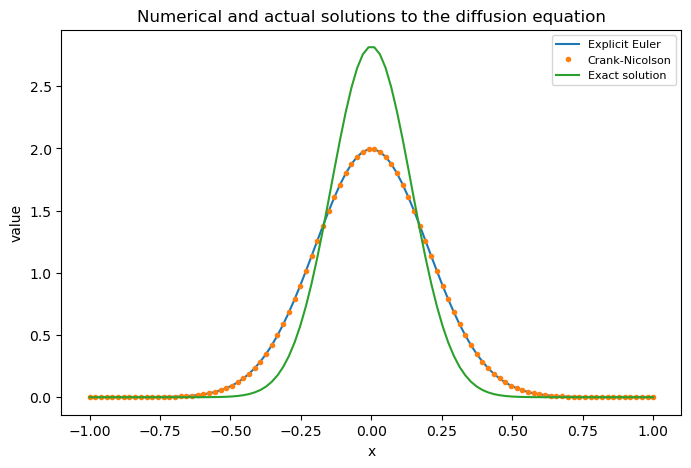

In [188]:
# code to plot exact and numerical solutions

fig, ax = plt.subplots(1, 1, figsize=[8, 5])

#plot results
ax.plot((x), c_EE[:,-1], label='Explicit Euler')
ax.plot((x), c_CN[:,-1], '.',  label='Crank-Nicolson')
ax.plot((x), (4*np.pi*kappa*10)**(-0.5)*np.exp(-x**2 / (4*kappa*10)), label='Exact solution')

#format figure
ax.legend(fontsize=8)
ax.set_ylabel('value')
ax.set_xlabel('x')
ax.set_title('Numerical and actual solutions to the diffusion equation')

Now, define a measure of the error of each numerical method compared to the exact solution (there is no single correct way to do this). Plot the error of both methods as a function of the grid spacing $\Delta x$. Then, similarly plot the error as a function of the timestep, $\Delta t$.

DISCUSS DEFINITION OF ERROR

Root mean square error is a measure of the difference between the exact values and the values using the numerical method.

$$RMSE=\sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i-\hat{y}_i)^2}$$

$$n=number\ of\ data\ points\\
y=predicted\ value\\
\hat{y}=actual\ value$$






In [190]:
#define a function that calculates the exact solution
def e_solution(x,kappa,t):

    return (4*np.pi*kappa*t)**(-0.5)*np.exp(-x**2 / (4*kappa*t))

# Create an empty sparse array to store the solution
es = np.zeros((Nx, 1))
es[:,0]=e_solution(x,kappa,10)

Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.02 seconds
Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.02 seconds
Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.02 seconds
Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.02 seconds
Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.02 seconds
Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.02 seconds
Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.02 seconds
Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.02 seconds
Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.02 seconds
Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.02 seconds
Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.01 seconds
Explicit Euler method took 0.01 seconds


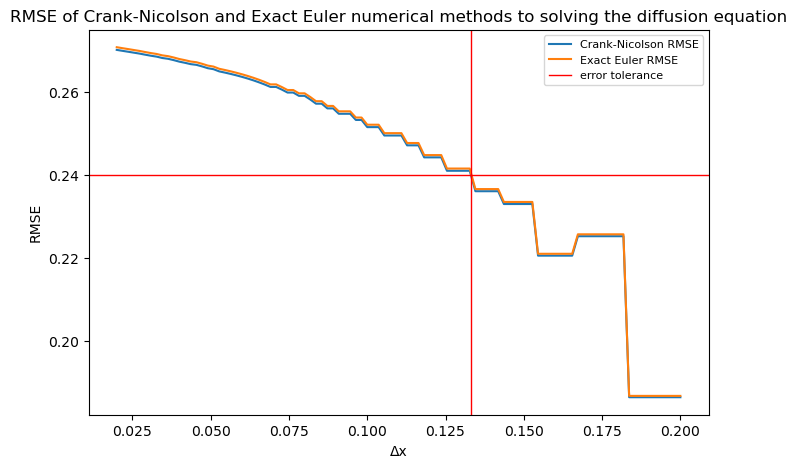

In [192]:
#root mean square error of both methods as a function of the grid spacing  Δ𝑥

#considering error at t=10s

#create figure

fig, ax = plt.subplots(1, 1, figsize=[8, 5])

#create empty list to store RMSE values
rmse_values_CN=[]
rmse_values_EE=[]

# create array of  Δ𝑥
delx_array=np.linspace(0.02,0.2,100)

#loop over Δ𝑥 values
for delx in delx_array:

    #array of x values for current delx
    x=np.linspace(-1,1,int(2/delx))

    # Create an array for t
    t = np.linspace(0, 10, 100)

    # Run the simulations
    c_EE = EE(x, t, kappa) # explicit Euler
    c_CN = CN(x, t, kappa) # Crank-Nicolson 

    #create empty arrays to store solution
    es=np.zeros((len(x),1))
    es[:,0]=e_solution(x,kappa,10)

    # Calculate the mean squared error (MSE) by taking the mean of the squared differences
    meanSquaredError_CN = ((c_CN[:,-1] - es[:,0]) ** 2).mean()
    meanSquaredError_EE = ((c_EE[:,-1] - es[:,0]) ** 2).mean()

    rmse_CN=np.sqrt(meanSquaredError_CN)
    rmse_EE=np.sqrt(meanSquaredError_EE)

    rmse_values_CN.append(rmse_CN)
    rmse_values_EE.append(rmse_EE)
    

#plot graph
ax.plot(delx_array, rmse_values_CN, label='Crank-Nicolson RMSE')
ax.plot(delx_array, rmse_values_EE, label='Exact Euler RMSE')



ax.set_ylabel('RMSE')
ax.set_xlabel('Δx')
ax.set_title('RMSE of Crank-Nicolson and Exact Euler numerical methods to solving the diffusion equation')
    

ax.axhline(y=0.24, color='r', linestyle='-', linewidth=1, label=f'error tolerance')
ax.axvline(x=0.133,color='r', linestyle='-', linewidth=1)
ax.legend(fontsize=8)


Explicit Euler method took 0.55 seconds
Crank-Nicolson method took 0.46 seconds
Explicit Euler method took 0.27 seconds
Crank-Nicolson method took 0.25 seconds
Explicit Euler method took 0.25 seconds
Crank-Nicolson method took 0.19 seconds
Explicit Euler method took 0.14 seconds
Crank-Nicolson method took 0.13 seconds
Explicit Euler method took 0.11 seconds
Crank-Nicolson method took 0.17 seconds
Explicit Euler method took 0.10 seconds
Crank-Nicolson method took 0.10 seconds
Explicit Euler method took 0.09 seconds
Crank-Nicolson method took 0.09 seconds
Explicit Euler method took 0.08 seconds
Crank-Nicolson method took 0.08 seconds
Explicit Euler method took 0.07 seconds
Crank-Nicolson method took 0.08 seconds
Explicit Euler method took 0.06 seconds
Crank-Nicolson method took 0.07 seconds
Explicit Euler method took 0.05 seconds
Crank-Nicolson method took 0.06 seconds
Explicit Euler method took 0.05 seconds
Crank-Nicolson method took 0.06 seconds
Explicit Euler method took 0.05 seconds


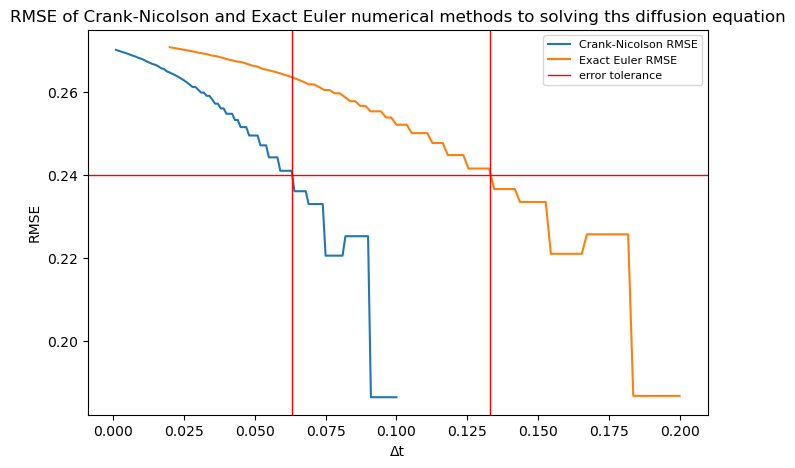

In [193]:
#root mean square error of both methods as a function of the timestep  Δt

#considering error at t=10s

#create figure

fig, ax = plt.subplots(1, 1, figsize=[8, 5])

#create empty list to store RMSE values
rmse_values_CN_delt=[]
rmse_values_EE_delt=[]

# create array of  Δt
delt_array=np.linspace(0.001,0.1,100)

#loop over Δ𝑥 values
for delt in delt_array:

    #array of x values for current delx
    t=np.linspace(0,10,int(10/delt))

    # Create an array for x
    x = np.linspace(-1, 1, 100)

    # Run the simulations
    c_EE = EE(x, t, kappa) # explicit Euler
    c_CN = CN(x, t, kappa) # Crank-Nicolson 

    #create empty arrays to store solution
    es=np.zeros((len(x),1))
    es[:,0]=e_solution(x,kappa,10)

    # Calculate the mean squared error (MSE) by taking the mean of the squared differences
    meanSquaredError_CN = ((c_CN[:,-1] - es[:,0]) ** 2).mean()
    meanSquaredError_EE = ((c_EE[:,-1] - es[:,0]) ** 2).mean()

    rmse_CN=np.sqrt(meanSquaredError_CN)
    rmse_EE=np.sqrt(meanSquaredError_EE)

    rmse_values_CN_delt.append(rmse_CN)
    rmse_values_EE_delt.append(rmse_EE)
    

#plot graph
ax.plot(delt_array, rmse_values_CN, label='Crank-Nicolson RMSE')
ax.plot(delx_array, rmse_values_EE, label='Exact Euler RMSE')



ax.set_ylabel('RMSE')
ax.set_xlabel('Δt')
ax.set_title('RMSE of Crank-Nicolson and Exact Euler numerical methods to solving ths diffusion equation')

#plotting lines for error tolerance
ax.axhline(y=0.24, color='r', linewidth=1, linestyle='-', label=f'error tolerance')
ax.axvline(x=0.133,color='r', linewidth=1, linestyle='-')
ax.axvline(x=0.063,color='r', linewidth=1, linestyle='-')
ax.legend(fontsize=8)

Finally, select a given error tolerance and explore whether explicit Euler or Crank-Nicoslon is more efficient (faster) at generating solutions with error less than your error tolerance. Discuss your conclusion and add supporting figures if necessary.

INSERT DISCUSSION OF ERROR HERE (~1 paragraph).  OPTIONALLY ADD PLOTS BY INSERTING A CODE BLOCK BELOW.

The RMSE decreases as the size of the grid spacing or timestep increases. The RMSE is very similiar for Crank-Nicolson and Explicit Euler for a given grid spacing but the RMSE is smaller for the Crank-Nicolson for a given timestep size.

Selecting an error tolerance of RMSE=0.24. Using both graphs above to approximate the size of the grid spacing and timestep to get an error tolerance less than 0.24 gives Δx=0.133 and Δt=0.133 for Crank-Nicolson and Δx=0.133 and Δt=0.633 for the Exact Euler method. Running the two methods below shows that the time taken for the Explicit Euler (rounded to) 0.0 seconds and the time for Crank-Nicolson (rounded to) 0.2s. Hence Explicit Euler is faster at generating solutions with error less that the error tolerance of 0.24. However, this conclusion may not be robust as there are errors in  visually estimating the Δt and  Δx for an error tolerance of 0.24 from the graph and Nt was rounded by a different amount for each method to make it an interger.



In [194]:
#determine run time for Explicit Euler and Crank Nicolson to produce a RMSE=0.24

#run Explicit Euler with Δx=0.133 and Δt=0.633

# Changing number of timesteps and number of grid spacings
Nt = 15 #10/0.633  # number of timesteps # rounding Nt down becuase as Δt increases the RMSE error decreases and will remain below the threhold.

Nx = 15 # ~ (size of x domain)/ Δx = 2/0.133=15.037  # rounding Nx down becuase as Δx increases the RMSE error decreases and will remain below the threhold.


t = np.linspace(t_start, t_end, Nt)  # Create a vector of times
x = np.linspace(x_start, x_end, Nx)  # Create a vector for x

# Run the simulation
c_EE = EE(x, t, kappa) # explicit Euler


Explicit Euler method took 0.00 seconds


In [195]:
#run Crank-Nicolson with Δx=0.133 and Δt=0.133

# Changing number of timesteps and number of grid spacings
Nt=75   # rounding Nt down becuase as Δt increases the RMSE error decreases and will remain below the threhold.

Nx=15   # rounding Nx down becuase as Δx increases the RMSE error decreases and will remain below the threhold.

c_CN = CN(x, t, kappa) # Crank-Nicolson


Crank-Nicolson method took 0.01 seconds


Now, move to Project1_dedalus.ipynb which will introduce Dedalus and spectral methods.

### 3. Optional further investigations

The application of the boundary conditions for the Crank-Nicolson method isn't quite right in the script above (but the boundary conditions aren't very important in this example). Account for the boundary conditions by modifying the coefficient matrix. This ensures that the boundary conditions are applied to the implicit and explicit terms involved in the Crank-Nicolson update. How would you handle fixed value (Dirichlet) and fixed gradient (Neumann) boundary conditions?